In [1]:
from ngrams import Ngram

In [2]:
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

# Load objects and preprocess

In [3]:
obj_tbl = pd.read_csv("../../data/tables/Objects.csv.gz")
str_cols = "Title", "Description"
txts = [s for col in str_cols for s in obj_tbl[col].dropna()]
tokens = [w for txt in txts for w in txt.split()]

print("number of docs: ", len(txts))
print("number of tokens: ", len(tokens))
print("number of types: ", len(set(tokens)))
print("TTR: ", round(len(set(tokens))/len(tokens), 4))

number of docs:  11199
number of tokens:  274580
number of types:  43518
TTR:  0.1585


# Initialise PMI engine

i.e. count word pairs, compute probabilities and PMI

`PMI(w1, w2) = log(P(w2|w1)/P(w2)) = log(P(w1|w2)/P(w1))`

In [4]:
NG = Ngram(2, txts, precompute_freqs=True)

(1, 2)-grams: Padding documents...: 100%|██████████| 11199/11199 [00:00<00:00, 1243139.09it/s]


(1, 2)-grams: Term Document Matrix constructed...
(1, 2)-grams: Term frequencies precomputed...
(1, 2)-grams: Init done


In [5]:
pmis = {w: NG.pmi(*w.split()) for w in NG.vocab(2)}

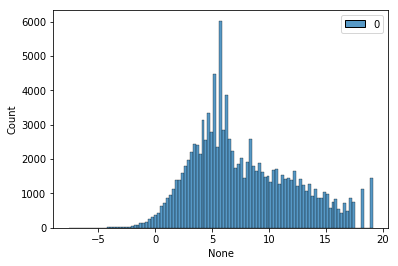

In [6]:
sns.histplot(pmis.values())

# Word Level

In [29]:
mens = "mens"
mens_pairs = {w for w in NG.vocab(2) if mens in w}

sorted_pmis = [(w, pmis[w]) for w in sorted(mens_pairs, key=lambda w: pmis[w])]

pd.DataFrame(sorted_pmis, columns=["pair", "PMI"])

,pair,PMI
0,een mensen,-1.353165
1,met mensen,-0.455868
2,mensen de,-0.211570
3,mensen </s>,0.357199
4,mensfiguren </s>,0.487596
...,...,...
389,thila bovenmenselijke,17.563169
390,royle namens,17.563169
391,menstruatieperiode voorbij,18.148131
392,mensenhoofden juwelensnoer,18.148131


In [15]:
{w for w in NG.vocab(1) if focus_word in w}

{'bovenmenselijke',
 'clemens',
 'dagjesmensen',
 'dimensie',
 'dimensional',
 'driedimensionaal',
 'immense',
 'inkomensbron',
 'medemens',
 'mens',
 'mensachtige',
 'mensch',
 'menselijk',
 'menselijke',
 'mensen',
 'mensenbeeld',
 'mensenbeenderen',
 'mensenbenen',
 'mensenbotten',
 'mensenfiguren',
 'mensenfiguur',
 'mensengelaat',
 'mensengezicht',
 'mensenhaar',
 'mensenhanden',
 'mensenheugenis',
 'mensenhoofd',
 'mensenhoofden',
 'mensenlichaam',
 'mensenpatroon',
 'mensenroof',
 'mensenschedel',
 'mensfiguren',
 'mensfiguur',
 'mensfiguurtje',
 'mensfiguurtjes',
 'mensheid',
 'menskopje',
 'menstruatie',
 'menstruatieperiode',
 'mensvormig',
 'mensvormige',
 'namens',
 'oermens',
 'samensmelting',
 'samenstel',
 'samenstelde',
 'samenstelden',
 'samenstelling',
 'tweedimensionaal'}

# Object Level

scoring heuristic for objects based on PMI values of word pairs

In [68]:
replace = lambda t: t if type(t) is str else ""

# scores = []
# for j, row in tqdm(obj_tbl.iterrows(), total=obj_tbl.shape[0]):
#     tl, tx = row.Title, row.Description

#     pairs = [w for t in (replace(tl), replace(tx)) for w in NG.iter_ngrams(t)]
#     scores.append(np.mean([pmis[w] for w in pairs]))
    
    
    
scores = []


for j, row in tqdm(obj_tbl.iterrows(), total=obj_tbl.shape[0]):
    tl, tx = row.Title, row.Description
    pairs = [w for t in (replace(tl), replace(tx)) for w in NG.iter_ngrams(t)]
    scores.append((np.mean([pmis[w] for w in pairs])))
obj_tbl = obj_tbl.assign(avg_PMI=scores)

100%|██████████| 10537/10537 [00:01<00:00, 5868.42it/s]


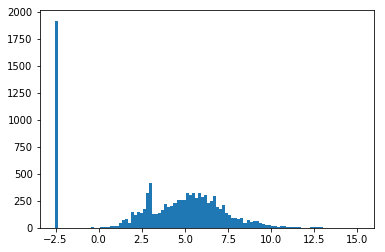

In [69]:
# _=plt.hist(obj_tbl.avg_PMI[obj_tbl.avg_PMI< 10000], bins=100)
# _=plt.xlim(-10, 1000.0)

_=plt.hist(obj_tbl.avg_PMI, bins=100)

In [76]:
has_mens = obj_tbl.Description.apply(lambda t: focus_word in t if type(t) is str else False)
obj_tbl[has_mens].sort_values(by="avg_PMI")[["ObjectID", "Title", "Description", "avg_PMI"]]

,ObjectID,Title,Description,avg_PMI
4515,1120402,NaN,[VO] mensengezicht met haar en baard,3.137183
10301,1090527,NaN,[DE] dansend mensfiguur,3.515280
9406,1184817,NaN,Afbeelding van een grote groep negroïde mensen...,4.123839
2008,125020,BAK VERSIERD MET MENS- EN DIERFIGUREN,Schuitvormige bak met rechthoekig uitgehold de...,4.452035
3852,185437,AARDEWERK PIJPENKOP,De pijpenkop is vervaardigd van terracotta. Op...,4.493420
...,...,...,...,...
6801,125226,BRONZEN BEELD VAN DE DANSENDE SHIVA,"Shiva Nataraja, de dansende Shiva.\r\n\r\nMet ...",8.714545
727,905210,' ABORIGINAL CEREMONIAL 'THE BORA TREE',De Kerry & Co studio \r\nDe Kerry & Co studio ...,8.774003
3287,754671,NAKNOK MASKER,"Naxnox mask; Tsimshian, probably Nishga; ca. 1...",9.608883
5446,1046747,zonder titel,The main theme in the paintings from Utopia is...,10.691944


In [91]:
for k, v in dict(obj_tbl.iloc[5446]).items():
    print(k, ":\t", (v[:1500] if type(v) is str else v))

ObjectID :	 1046747
DepartmentID :	 9
ClassificationID :	 154
ObjectName :	 schildering
Title :	 zonder titel
Description :	 The main theme in the paintings from Utopia is the strong bond that the Aborigines have with their country. Men paint the " Songlines":  the roads that the mythological ancestors travelled when they gave the world her shape. Traditionally you will find in these paintings concentric circles and connecting lines so that the artworks look like topographical maps. 
Most of the paintings of Utopia consist of dots and circles. The men were the first to transfer to  the acrylic-canvas medium. Their work is highly symbolic: representing ancestral history and nomadic routes. The paintings often look like maps, seen from the sky. Only a person with considerable knowledge of the depicted locations and the dreamings related to them can understand the symbols properly. A circle may represent a campsite, waterhole or fire. An  arc represent  a person, whether man or woman will